# Приоритизация и проверка гипотез по увеличению выручки в интернет-магазине

Совместно с отделом маркетинга крупного интернет-магазина подготовлен список гипотез для увеличения выручки.  
Задача - приоритизировать гипотезы, провести A/B-тест и проанализировать результаты.   

Датасет hypothesis содержит 9 гипотез по увеличению выручки интернет-магазина с параметрами Reach, Impact, Confidence, Effort:     
    Hypothesis — краткое описание гипотезы;  
    Reach — охват пользователей по 10-балльной шкале;  
    Impact — влияние на пользователей по 10-балльной шкале;  
    Confidence — уверенность в гипотезе по 10-балльной шкале;  
    Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале.
    
Датасеты orders и visitors содержат описания результатов А/В-теста.   
Датасет orders:  
    transactionId — идентификатор заказа;  
    visitorId — идентификатор пользователя, совершившего заказ;  
    date — дата, когда был совершён заказ;  
    revenue — выручка заказа;  
    group — группа A/B-теста, в которую попал заказ.  
    
Датасет visitors:  
    date — дата;  
    group — группа A/B-теста;  
    visitors — количество пользователей в указанную дату в указанной группе A/B-теста.  

[1  Загрузка и подготовка данных](#1)   
[2  Приоритизация гипотез](#2)  
[3  Анализ A/B-теста](#3)   
[3.1  График кумулятивной выручки по группам](#3.1)  
[3.2  График кумулятивного среднего чека по группам](#3.2)  
[3.3  График относительного изменения кумулятивного среднего чека группы B к группе A](#3.3)  
[3.4  График кумулятивной конверсии по группам](#3.4)  
[3.5  График относительного изменения кумулятивной конверсии группы B к группе A](#3.5)  
[3.6  Точечный график количества заказов по пользователям](#3.6)  
[3.7  Расчет 95-го и 99-го перцентилей количества заказов на пользователя](#3.7)  
[3.8  Точечный график стоимостей заказов](#3.8)  
[3.9  Расчет 95-го и 99-го перцентилей стоимости заказов](#3.9)  
[3.10  Статистическая значимость различий в конверсии и в среднем чеке заказа между группами по «сырым» данным](#3.10)  
[3.11  Статистическая значимость различий в конверсии и в среднем чеке заказа между группами по «очищенным» данным](#3.11)  
[3.12  Выводы и решение по результатам теста](#3.12)  
[4  Выводы](#4)   

## Загрузка и подготовка данных
<a id='1'></a>

In [1]:
import pandas as pd
from scipy import stats as st
import scipy.stats as stats
import numpy as np
import datetime as dt
from math import factorial
from scipy.stats import norm
import matplotlib.pyplot as plt 
import math
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.display.max_colwidth = 150

In [2]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')

def info (df):
    display(df.head(10))
    df.info()
    print('')
    print('Процент пропусков в данных:')
    print(df.isna().mean()*100)
    print('')
    print('Количество дубликатов:', df.duplicated().sum())
    print('-------------------------------------------------------')
    print('')

print('Гипотезы')
info (hypothesis)
print('Заказы')
info (orders)
print('Пользователи')
info (visitors)

Гипотезы


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
Hypothesis    9 non-null object
Reach         9 non-null int64
Impact        9 non-null int64
Confidence    9 non-null int64
Efforts       9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes

Процент пропусков в данных:
Hypothesis    0.0
Reach         0.0
Impact        0.0
Confidence    0.0
Efforts       0.0
dtype: float64

Количество дубликатов: 0
-------------------------------------------------------

Заказы


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
6,398296753,2900797465,2019-08-15,1860,B
7,2626614568,78758296,2019-08-15,1044,A
8,1576988021,295230930,2019-08-15,13710,A
9,1506739906,1882260405,2019-08-15,1855,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB

Процент пропусков в данных:
transactionId    0.0
visitorId        0.0
date             0.0
revenue          0.0
group            0.0
dtype: float64

Количество дубликатов: 0
-------------------------------------------------------

Пользователи


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
5,2019-08-06,A,667
6,2019-08-07,A,644
7,2019-08-08,A,610
8,2019-08-09,A,617
9,2019-08-10,A,406


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB

Процент пропусков в данных:
date        0.0
group       0.0
visitors    0.0
dtype: float64

Количество дубликатов: 0
-------------------------------------------------------



In [3]:
a = orders.loc[orders['group'] == 'A', 'visitorId']
print('Количество пользователей группы А, попавших и в группу В:', orders[(orders['visitorId'].isin(a))&(orders['group'] == 'B')]['visitorId'].nunique())

Количество пользователей группы А, попавших и в группу В: 58


In [4]:
orders['date'] = pd.to_datetime(orders['date'])
visitors['date'] = pd.to_datetime(visitors['date'])
hypothesis.columns = map(str.lower, hypothesis.columns)
hypothesis

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


### Вывод

В данных нет пропусков и полных дубликатов. Тип данных в столбцах с датами заменен на datetime64. Наименования столбцов в датасете с гипотезами приведены к нижнему регистру.  
Возможно, произошла какая-то ошибка с распределением пользователей по группам теста, в результате чего некоторые из них присутствуют и в той и в другой группе. Конечно, это может повлиять на результаты теста и на данную проблему необходимо обратить внимание. При этом если пользователи по какой-то технической причине действительно могли сделать заказы без и с учетом тестируемой гипотезы, удалять их некорректно. Но даже в случае ошибочного распределения по группам удаление таких покупателей не обязательно является лучшим решением, данные в той или иной степени все равно искажаются. В связи с этим, для анализа данного А/В теста пользователей, попавших в обе группы, решено не удалять.

## Приоритизация гипотез
<a id='2'></a>

Применим фреймворк ICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.

In [5]:
hypothesis['ICE'] = round((hypothesis['impact']*hypothesis['confidence']) / hypothesis['efforts'],1)
display(hypothesis[['hypothesis', 'ICE']].sort_values(by = 'ICE', ascending = False))

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.2
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.1
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.0


Применим фреймворк RICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.

In [6]:
hypothesis['RICE'] = (hypothesis['reach']*hypothesis['impact']*hypothesis['confidence']) / hypothesis['efforts']
display(hypothesis[['hypothesis', 'RICE']].sort_values(by = 'RICE', ascending = False))

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


In [7]:
hypothesis.sort_values(by = 'RICE', ascending = False).style.background_gradient(subset=['ICE', 'RICE'])

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.2,112
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7,56
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.3,40
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8,40
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.2,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.1,9
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2,4
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.3,4
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1,3


### Вывод

При способе приоритизации ICE наиболее перспективными гипотезами получились 8, 0 и 7: скидка в день рождения, добавление двух новых каналов привлечения трафика и добавление формы подписки на все основные страницы.  
При использовании способа RICE самым перспективным с большим отрывом выглядит добавление формы подписки на все основные страницы для сбора базы клиентов для email-рассылок. Далее следует гипотеза "Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа" и потом с равными баллами гипотезы о добавлении двух новых каналов привлечения трафика и показе на главной странице баннеров с актуальными акциями и распродажами для увеличения конверсии.  
Наиболее перспективная при использовании способа ICE гипотеза "Запустить акцию, дающую скидку на товар в день рождения" при приоритизации способом RICE заняла всего лишь пятое место, т.к. ее параметр REACH имеет наименьшее из возможных значений. А гипотеза "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок" за счет влияния на большое количество пользователей получила наибольший приоритет при применении RICE. По той же причине на втором месте оказалась гипотеза "Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа". 

## Анализ A/B-теста
<a id='3'></a>

### График кумулятивной выручки по группам
<a id='3.1'></a>

In [8]:
datesGroups = orders[['date','group']].drop_duplicates() 

ordersAggregated = datesGroups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg(
        {'date' : 'max', 'group' : 'max', 'transactionId' : pd.Series.nunique, 'visitorId' : pd.Series.nunique, 'revenue' : 'sum'}), axis=1).sort_values(
    by=['date','group'])

visitorsAggregated = datesGroups.apply(
    lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg(
        {'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(
    by=['date','group']) 

cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
cumulativeData

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845
...,...,...,...,...,...,...
57,2019-08-29,B,596,544,5559398,17708
58,2019-08-30,A,545,493,4022970,18037
59,2019-08-30,B,620,567,5774631,18198
60,2019-08-31,A,557,503,4084803,18736


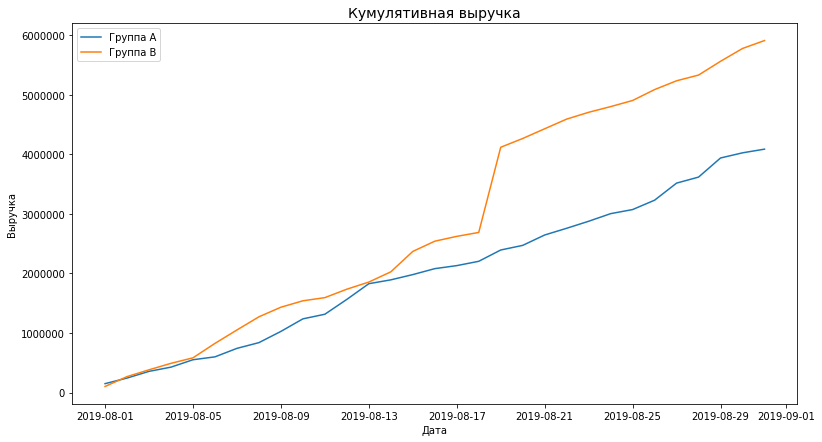

In [9]:
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize=(13, 7))

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='Группа A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='Группа B')

plt.legend() 
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.title('Кумулятивная выручка', fontsize=14)
plt.show()

Выручка группы В практически с самого начала теста превышает выручку группы А, и со временем разница между ними увеличивается за исключением короткого периода времени, когда выручки по двум группам были почти равны. При этом выручка группы А растет достаточно равномерно, а в выручке группы В был резкий скачок, что может быть следствием либо резкого числа заказов, либо аномально дорогих заказов. 

###  График кумулятивного среднего чека по группам
<a id='3.2'></a>

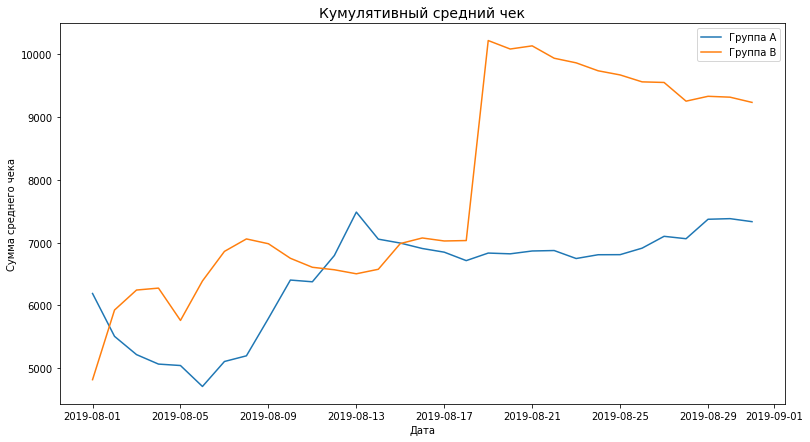

In [10]:
plt.figure(figsize=(13, 7))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='Группа A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='Группа B')
plt.xlabel('Дата')
plt.ylabel('Сумма среднего чека')
plt.legend() 
plt.title('Кумулятивный средний чек', fontsize=14)
plt.show()

В течение почти всего теста средний чек группы В превышал средний чек группы А. Равномерным средний чек в обеих группах становится ближе к концу, причем средний чек группы В постепенно снижается после огромного скачка. И в той и в другой группе средний чек периодически скачет, но особенно заметен, конечно, резкий скачок в среднем чеке группы В, что, почти точно, связано с выбросами в данных. 

### График относительного изменения кумулятивного среднего чека группы B к группе A
<a id='3.3'></a>

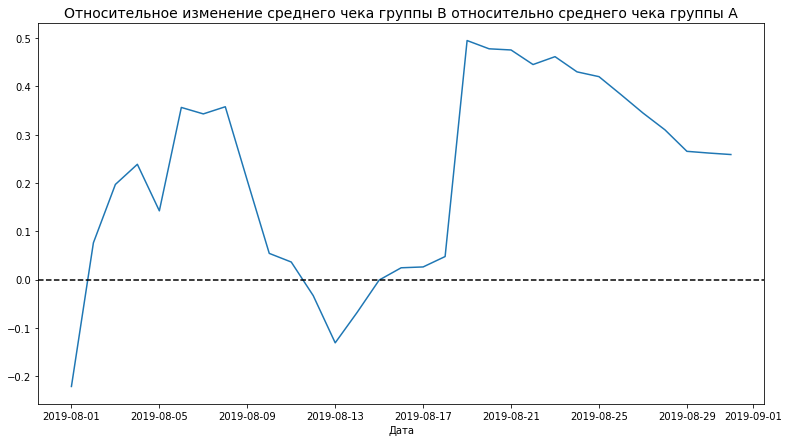

In [11]:
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(13, 7))
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
plt.title("Относительное изменение среднего чека группы B относительно среднего чека группы A", fontsize=14)
plt.xlabel('Дата')
plt.axhline(y=0, color='black', linestyle='--') 
plt.show()

В нескольких точках график различия между сегментами резко скачет. В данных явно есть аномальные заказы. 

### График кумулятивной конверсии по группам
<a id='3.4'></a>

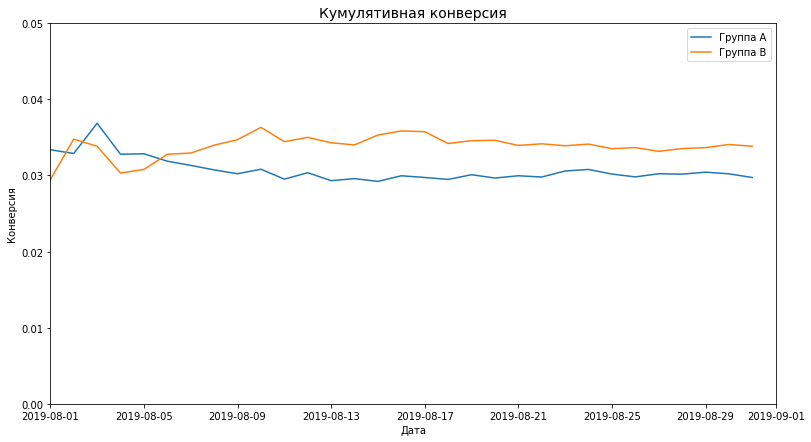

In [12]:
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

plt.figure(figsize=(13, 7))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='Группа A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='Группа B')
plt.xlabel('Дата')
plt.ylabel('Конверсия')
plt.legend()
plt.axis(["2019-08-01", '2019-09-01', 0, 0.05]) 
plt.title('Кумулятивная конверсия', fontsize=14)
plt.show()


В начале теста конверсия по группам колебалась, затем конверсия группы В превысила конверсию группы А, и вскоре после этого значения в обеих группах стали стабильными. 

### График относительного изменения кумулятивной конверсии группы B к группе A
<a id='3.5'></a>

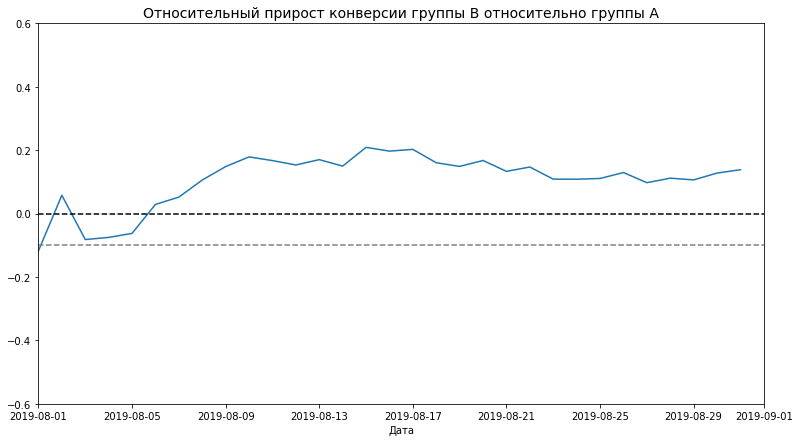

In [13]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize=(13, 7))
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1)
plt.title("Относительный прирост конверсии группы B относительно группы A", fontsize=14)
plt.xlabel('Дата')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')
plt.axis(["2019-08-01", '2019-09-01', -0.6, 0.6]) 
plt.show()

Конверсия группы B была меньше конверсии группы А только короткий период времени в начале теста, затем превысила конверсию группы А, достигла максимума примерно к середине теста и далее немного снизилась, по-прежнему оставаясь выше конверсии группы А.

### Точечный график количества заказов по пользователям
<a id='3.6'></a>

In [14]:
ordersByUsers = (
    orders.drop(['group', 'revenue', 'date'], axis=1)
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)

ordersByUsers.columns = ['visitorId', 'orders']

print(ordersByUsers.sort_values(by='orders', ascending=False).head(10))

       visitorId  orders
1023  4256040402      11
591   2458001652      11
569   2378935119       9
487   2038680547       8
44     199603092       5
744   3062433592       5
55     237748145       5
917   3803269165       5
299   1230306981       5
897   3717692402       5


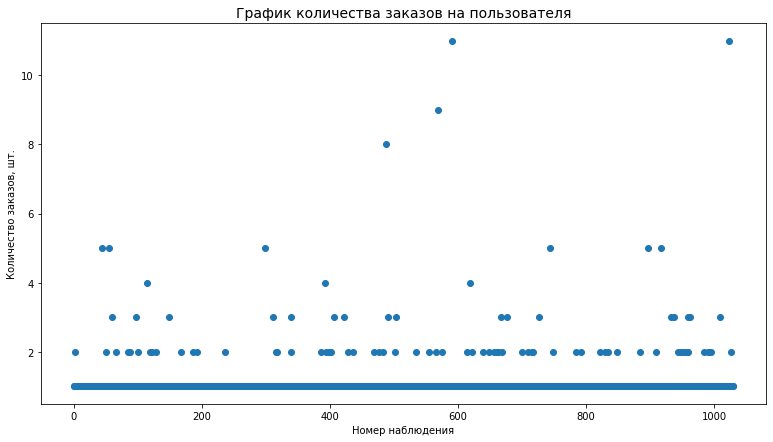

In [15]:
x_values = pd.Series(range(0,len(ordersByUsers)))
plt.figure(figsize=(13, 7))
plt.scatter(x_values, ordersByUsers['orders']) 
plt.title("График количества заказов на пользователя", fontsize=14)
plt.xlabel('Номер наблюдения')
plt.ylabel('Количество заказов, шт.')
plt.show()

Немногие пользователи делают 4 и больше заказов. Но для понимания их точной доли необходимо посчитать выборочные перцентили количества заказов на пользователя.

### Расчет 95-го и 99-го перцентилей количества заказов на пользователя
<a id='3.7'></a>

In [16]:
print(np.percentile(ordersByUsers['orders'], [95, 99]))

[2. 4.]


Не более 5% пользователей оформляли более двух заказов. И всего 1% пользователей заказывали более четырех раз. 
Для определения аномальных пользователей выберем нижнюю границу числа заказов на одного пользователя равную 3.

### Точечный график стоимостей заказов
<a id='3.8'></a>

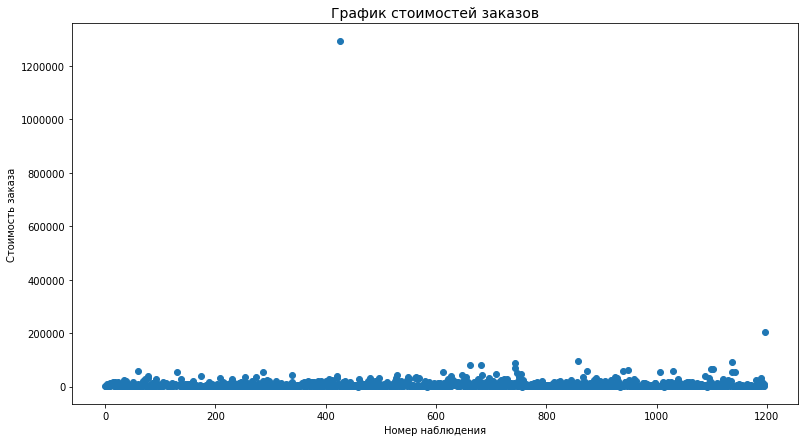

In [17]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.figure(figsize=(13, 7))
plt.scatter(x_values, orders['revenue']) 
plt.title("График стоимостей заказов", fontsize=14)
plt.xlabel('Номер наблюдения')
plt.ylabel('Стоимость заказа')
plt.show()

А вот, видимо, и тот заказ, который был причиной резких скачков кумулятивной выручки и среднего чека группы В. Он настолько больше стоимости остальных заказов, что при таком масштабе даже непонятно, с какой суммы заказов начинаются редкие значения.   
Построим точечный график без этого заказа. 

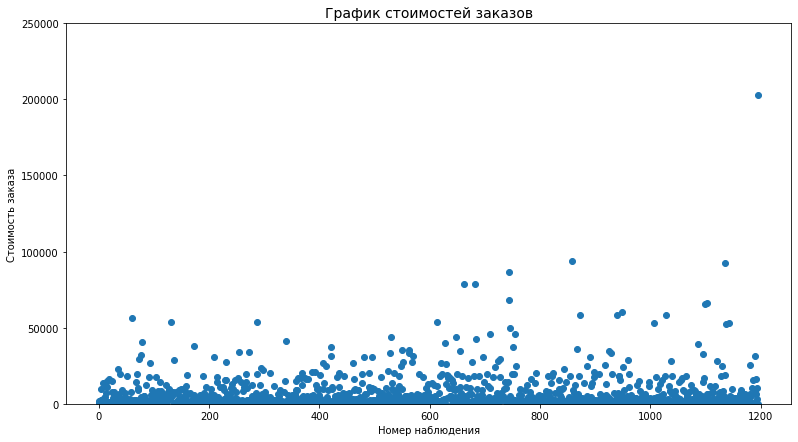

In [18]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.figure(figsize=(13, 7))
plt.scatter(x_values, orders['revenue']) 
plt.ylim(0,250000)
plt.title("График стоимостей заказов", fontsize=14)
plt.xlabel('Номер наблюдения')
plt.ylabel('Стоимость заказа')
plt.show()

Теперь лучше видно, что к аномальным заказам можно отнести заказы дороже примерно 30000 - 50000. Но точную долю по графику не определить. 

In [19]:
orders[orders['revenue']>100000]['group']

425     B
1196    B
Name: group, dtype: object

И, ожидаемо, два самых дорогих заказа были сделаны покупателями из группы В.

### Расчет 95-го и 99-го перцентилей  стоимости заказов
<a id='3.9'></a>

In [20]:
print(np.percentile(orders['revenue'], [95, 99])) 

[28000.  58233.2]


Не более 5% заказов дороже 28 000 и не более 1% дороже 58 233. Примем за аномальных пользователей тех, кто совершил заказ дороже 35 000.

### Статистическая значимость различий в конверсии и в среднем чеке заказа между группами по «сырым» данным
<a id='3.10'></a>

In [21]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

display(data.head(10)) 

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280
5,2019-08-06,18,48484,28,242342,127,598401,129,824337,667,655,3985,3935
6,2019-08-07,18,142417,24,225334,145,740818,153,1049671,644,709,4629,4644
7,2019-08-08,16,96279,27,220918,161,837097,180,1270589,610,654,5239,5298
8,2019-08-09,16,188506,25,160812,177,1025603,205,1431401,617,610,5856,5908
9,2019-08-10,16,210495,23,107802,193,1236098,228,1539203,406,369,6262,6277


In [22]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitorId', 'orders'] 

sampleA = pd.concat(
    [ordersByUsersA['orders'],pd.Series(0, index=np.arange(
        data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat(
    [ordersByUsersB['orders'],pd.Series(0, index=np.arange(
        data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

Проверим гипотезы на "сырых" данных:  

Нулевая гипотеза: Различий в конверсии между группами А и В нет.  

Альтернативная гипотеза: В конверсии между группами А и В есть статистически значимые различия.


In [23]:
print("p-value: {0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB, alternative='two-sided')[1]))

print("Относительный прирост конверсии группы B: {0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

p-value: 0.017
Относительный прирост конверсии группы B: 0.138


p-value < 0.05, поэтому нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, отвергаем. Таким образом, различие в конверсии групп A и B по «сырым» данным статистически значимо.   
При этом относительный прирост конверсии группы B к группе А равен 13.8%.

Проверим гипотезы на "сырых" данных: 

Нулевая гипотеза: Различий в среднем чеке групп А и В нет.  

Альтернативная гипотеза: В среднем чеке групп А и В есть статистически значимые различия.


In [24]:
print('p-value: {0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'], alternative='two-sided')[1]))
print('Относительный прирост среднего чека группы B: {0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

p-value: 0.729
Относительный прирост среднего чека группы B: 0.259


p-value значительно больше 0.05. Причин отвергать нулевую гипотезу об отсутствии статистически значимых различий в среднем чеке нет. Но при этом средний чек группы B выше среднего чека группы A на 25,9%.

### Статистическая значимость различий в конверсии и в среднем чеке заказа между группами по «очищенным» данным
<a id='3.11'></a>

In [25]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 3]['visitorId'],
        ordersByUsersB[ordersByUsersB['orders'] > 3]['visitorId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 35000]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head())
print('Количество аномальных пользователей:', abnormalUsers.shape[0]) 

1099    148427295
18      199603092
23      237748145
684     358944393
648     382846391
Name: visitorId, dtype: int64
Количество аномальных пользователей: 42


In [26]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 


Проверим гипотезы на "очищенных" данных:

Нулевая гипотеза: Различий в конверсии между группами А и В нет.

Альтернативная гипотеза: В конверсии между группами А и В есть статистически значимые различия.


In [27]:
print('p-value: {0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered, alternative='two-sided')[1]))
print('Относительный прирост конверсии группы B: {0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

p-value: 0.014
Относительный прирост конверсии группы B: 0.155


Для "очищенных" данных почти ничего не поменялось. Р-value примерно такой же, следовательно, различие в конверсии групп A и B остается статистически значимым.  
Относительный прирост конверсии группы B к группе А увеличился почти на 2% и стал 15,5%.

Проверим гипотезы на "очищенных" данных:

Нулевая гипотеза: Различий в среднем чеке групп А и В нет.

Альтернативная гипотеза: В среднем чеке групп А и В есть статистически значимые различия.


In [28]:
print(
    'p-value: {0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'], alternative='two-sided'
        )[1]
    )
)

print(
    "Относительный прирост среднего чека группы B: {0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
) 

p-value: 0.874
Относительный прирост среднего чека группы B: 0.025


р-value увеличился, разница между группами сократилась с 26% до 2,5%. Статистически значимых различий в среднем чеке нет и по "очищенным" данным тоже. 

### Выводы и решение по результатам теста
<a id='3.12'></a>

По результатам теста можно сделать следующие выводы:  
Нет статистически значимого различия в среднем чеке между группами ни по "сырым", ни по "очищенным" данным.  
По конверсии между группами есть статистически значимое различие до и после удаления аномалий. Конверсия в группе В выше, чем в группе А.  
График относительного прироста конверсии группы B относительно группы A также показывает, что конверсия группы В стабильно выше и, возможно, имеет тендецию к дальнейшему росту.  
Таким образом, можно признать тест успешным и остановить его. Результаты группы В лучше группы А. За счет увеличения конверсии тестируемая гипотеза позволит интернет-магазину увеличить выручку.

## Вывод
<a id='4'></a>

По итогам использования способов приоритизации гипотез ICE и RICE можно выделить следующие наиболее перспективные гипотезы по увеличению выручки:  
Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок  
Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей  
Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа  
Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию  

В данных с результатами А/В-теста было выявлено попадание 58 пользователей и в группу А и в группу В.  
А/В-тест можно признать успешным, достигнуто статистически значимое различие между конверсиями в группах А и В. Конверсия в группе В выше, что позволяет увеличить выручку интернет-магазина. 